In [1]:
import pandas as pd 
import numpy as np 
from skimage.io import imread 
import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.model_selection import train_test_split 

from sklearn.metrics import accuracy_score 
from tqdm import tqdm 

import torch 
from torch.autograd import Variable 
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [2]:
import torchvision 
import torchvision.transforms as transforms
from torchvision import datasets

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)), ])

#transform = transforms.Compose([transforms.ToTensor()])
            
batch_size = 32

trainset = datasets.ImageFolder('/home/dh26/Documents/Carla/gym-carla/CNN_images/Training_Set', transform = transform)
testset = datasets.ImageFolder('/home/dh26/Documents/Carla/gym-carla/CNN_images/Testing_Set', transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

classes = ('Cloudy','Dry','HeavyRain','LightRain')

In [4]:
trainset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: /home/dh26/Documents/Carla/gym-carla/CNN_images/Training_Set
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.axis('off')
    plt.show()

In [6]:
dataiter = iter(trainloader)

In [7]:
images,labels = dataiter.next()

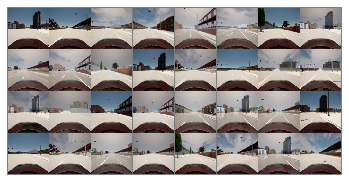

In [8]:
imshow(torchvision.utils.make_grid(images))

In [9]:
images.shape

torch.Size([32, 3, 128, 128])

In [10]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

LightRain LightRain HeavyRain HeavyRain Dry   Dry   LightRain Cloudy Dry   Dry   Cloudy LightRain Cloudy LightRain HeavyRain HeavyRain Cloudy Cloudy LightRain Cloudy Dry   Dry   Dry   LightRain LightRain Cloudy Dry   Cloudy HeavyRain HeavyRain Dry   HeavyRain


In [18]:
import torch.nn as nn
import torch.nn.functional as F 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.pool = nn.MaxPool2d(3,3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(16,32,3)
        #self.pool = nn.MaxPool2d(3,3)
        self.conv4 = nn.Conv2d(32,32,3)
        #self.conv5 = nn.MaxPool2d(128,256,5)
        self.fc1 = nn.Linear(288,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,4)

        #self.loss = nn.Sigmoid()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [11]:

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net() #mat1 and mat2 shapes cannot be multiplied (3x126736 and 400x120)

In [19]:
net = Net()
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()
#criterion = nn.Softmax()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [20]:
import torch
torch.cuda.empty_cache()

Training Started.....
Continuing...
Continuing...
Continuing...
Continuing...
Continuing...
Continuing...
Continuing...
Continuing...
Continuing...
Continuing...


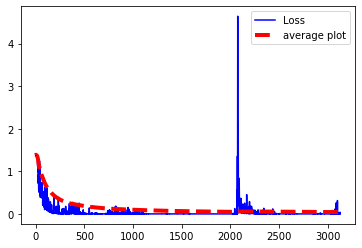

Finished Training


In [21]:
print('Training Started.....')
if torch.cuda.is_available():
    model = net.cuda()
    criterion = criterion.cuda()

n_epoch = 10


losses = []
avg_losses = []
for epoch in range(n_epoch):
    print('Continuing...')
    running_loss=0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs,labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss)
        avg_losses.append(sum(losses)/len(losses))
        if i % 2000 == 1999:
            print('f[{epoch + i}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss=0.0
# plt.plot(losses, label = 'Training Loss')
# plt.show()

fig, ax = plt.subplots()
ax.plot(losses, label='Loss', color='blue')
ax.plot(avg_losses,color='red', lw=4, ls='--', label="average plot")
plt.legend(loc=0)
plt.show()
print('Finished Training')

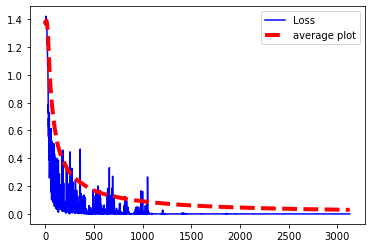

Finished Training


In [30]:
# fig, ax = plt.subplots()
# ax.plot(losses, label='Loss', color='blue')
# ax.plot(avg_losses,color='red', lw=4, ls='--', label="average plot")
# plt.legend(loc=0)
# plt.show()
# print('Finished Training')

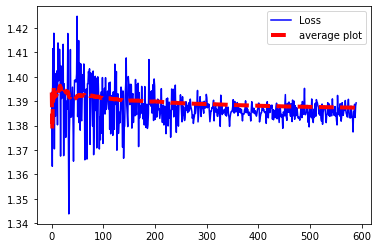

In [195]:
#Normalised images(0.5,0.5,0.5)(0.5,0.5,0.5)
#SGD optimizer(lr=0.001, momentum = 0.9)
#Test Accuracy 23%
# fig, ax = plt.subplots()
# ax.plot(losses, label='Loss', color='blue')
# ax.plot(avg_losses,color='red', lw=4, ls='--', label="average plot")
# plt.legend(loc=0)
# plt.show()

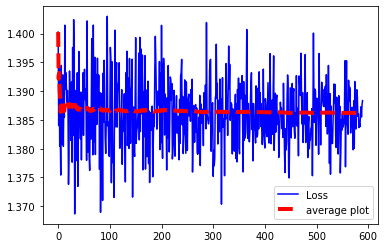

In [209]:
# SGD optimizer(lr=0.001, momentum = 0.9)
# Test Accuracy 23%
# fig, ax = plt.subplots()
# ax.plot(losses, label='Loss', color='blue')
# ax.plot(avg_losses,color='red', lw=4, ls='--', label="average plot")
# plt.legend(loc=0)
# plt.show()

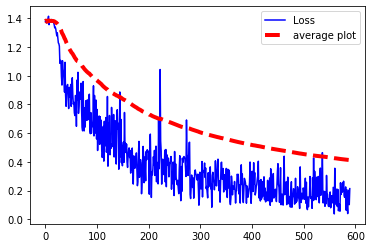

In [224]:
# Adam optimizer(lr=0.001)
#Normalised Images
# Test Accuracy 86%
# 10 epcohs
#batch size 32
# fig, ax = plt.subplots()
# ax.plot(losses, label='Loss', color='blue')
# ax.plot(avg_losses,color='red', lw=4, ls='--', label="average plot")
# plt.legend(loc=0)
# plt.show()

In [22]:
path = './Weather4.pt'
torch.save(net.state_dict(),path)

In [23]:
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [18]:
# correct = 0 
# total = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         images, labels = images.cuda(), labels.cuda()
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct +=(predicted == labels).sum().item()

# print("Accuracy of the network on the {} test images: {}%".format(len(testloader), 100*correct/total))

Accuracy of the network on the 17 test images: 84.85436893203884%


In [16]:
# correct = 0 
# total = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         images, labels = images.cuda(), labels.cuda()
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct +=(predicted == labels).sum().item()

# print("Accuracy of the network on the {} test images: {}%".format(len(testloader), 100*correct/total))

Accuracy of the network on the 125 test images: 99.4%


In [24]:
correct = 0 
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct +=(predicted == labels).sum().item()

print("Accuracy of the network on the {} test images: {}%".format(len(testloader), 100*correct/total))

Accuracy of the network on the 125 test images: 98.75%


In [1]:
loss

NameError: name 'loss' is not defined